In [2]:
include("../Inversion/Plot.jl")
include("../Inversion/KalmanInversion.jl")
include("Linear.jl")

forward (generic function with 1 method)

# Low-rank

Consider the 500-parameter linear inverse problem

$$y = G\theta + \eta.$$

with $\eta \sim \mathcal{N}(0, 0.1^2I)$. The forward model $G \in R^{N_y \times 500}$ is constructed as

$$G = U [I^{N_y} \quad 0] V^T$$

here $U \in R^{d \times d}$ and $V \in R^{500 \times N_y}$ are random orthogonal matrices





The prior is $\mathcal{N}(r_0, \Sigma_0) = \mathcal{N}(0, \sigma_0^2I^{500})$, the posterior is

$$\theta|y \sim \mathcal{N}\Big(r_0 + \Big(G^T \Sigma_{\eta}^{-1} G + \Sigma_0^{-1}\Big)^{-1} G^T\Sigma_{\eta}^{-1}(y - G r_0), \quad \Big(G^T \Sigma_{\eta}^{-1} G + \Sigma_0^{-1}\Big)^{-1} \Big)$$
   


In [281]:
Nθ = 10
Ny = 6
Nr_ref = 2
# construct G, todo U Σ Vᵀ
G = zeros(Float64, Ny, Nθ)
for i = 1:Nr_ref
    G[i, i] = 1.0
end

G_rand = rand(Normal(0.0, 1.0), Ny, Nθ)
svd_G = svd(G_rand)
U_ref, Vt_ref = svd_G.U, svd_G.Vt
S = zeros(Float64, Nr_ref, Nr_ref)
for i = 1:Nr_ref
    S[i, i] = 1.0
end
G = U_ref[:,1:Nr_ref] * S * Vt_ref[1:Nr_ref, :]


# construct prior
σ0 = 10.0
r0 = zeros(Float64, Nθ) 
Σ0 = zeros(Float64, Nθ, Nθ)
for i = 1:Nθ
    Σ0[i, i] = σ0^2
    
    if i < Nθ
        Σ0[i+1, i] = σ0^2/4
        Σ0[i, i+1] = σ0^2/4
    end
end

# construct solution, todo add noise
# θ_ref = Float64.(rand(Binomial(1, 0.5), Nθ))
θ_ref = ones(Float64, Nθ)
ση = 0.1
Ση = Diagonal(fill(ση^2, Ny))
η = rand(Normal(0.0, ση), Ny)
y = G*θ_ref # + η

# posterior distribution
θ_post  = r0 + (G'*(Ση\G) + inv(Σ0))\(G' * (Ση\(y - G*r0)));
θθ_post = inv(G'*(Ση\G) + inv(Σ0));

    

In [282]:
θ_post

10-element Vector{Float64}:
  0.24471568078622916
 -0.15726862582341927
  0.7446072313457096
 -0.3090221632229607
  0.25810120249687313
  0.5822652484735708
  0.47504338055807144
  0.5471583765088099
  0.11246663099835645
  0.21571503463397912

## Tikhonov UKI  approach $[y; \theta]$

In [283]:
function forward(s_param::Setup_Param, θ::Array{FT, 1}) where {FT<:AbstractFloat}
    G = s_param.G 
    return G * θ
end


function aug_prediction(y, θ)
    return [y; θ]
end

function aug_forward(s_param::Setup_Param, θ::Array{FT, 1}) where {FT<:AbstractFloat}
    G = s_param.G 
    return aug_prediction(G * θ, θ)
end



aug_forward (generic function with 1 method)

In [284]:
FT = Float64

α_reg = 1.0
update_freq = 1
N_iter = 20

# augmented system
s_param = Setup_Param(G, Nθ, Ny + Nθ)

θ0_mean = r0
θθ0_cov = Σ0  
aug_y = [y ;r0]
aug_Ση = [Ση zeros(Float64, Ny, Nθ); zeros(Float64, Nθ, Ny)  Σ0]
    
uki_objs = UKI_Run(s_param, aug_forward, 
    θ0_mean, θθ0_cov,
    aug_y, aug_Ση,
    α_reg,
    update_freq,
    N_iter);
    

┌ Info: ("optimization error at iter 1 = ", 72.3024580282437)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 1 = ", 333.54160160315837)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 2 = ", 0.009551926278205072)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 2 = ", 290.9562197593741)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 3 = ", 0.009550796111877834)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 3 = ", 290.9554698057819)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 4 = ", 0.009550680766925689)
└ @ Main /Users/huang/Desktop/Code/InverseProb

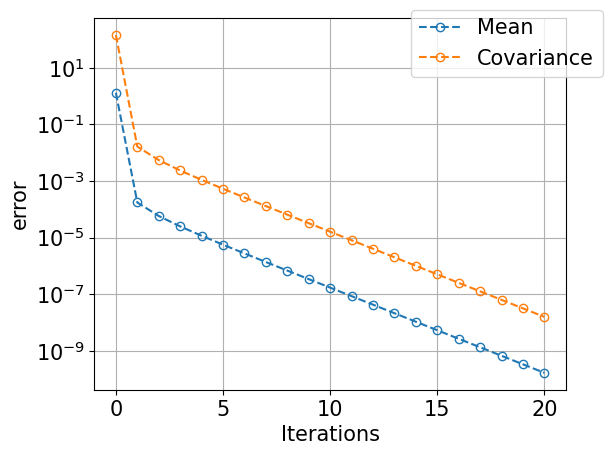

In [285]:
errors = zeros(FT, 2, N_iter+1)
for i = 1:N_iter+1
    errors[1, i] = norm(uki_objs.θ_mean[i] .- θ_post)
    errors[2, i] = norm(uki_objs.θθ_cov[i] .- θθ_post)
end


ites = Array(0:N_iter)
semilogy(ites, errors[1, :], "--o", fillstyle="none", label="Mean")
semilogy(ites, errors[2, :], "--o", fillstyle="none", label="Covariance")
xlabel("Iterations")
ylabel("error")
grid("on")
legend(bbox_to_anchor=(1.1, 1.05))
tight_layout()

## Random Embedding : Tikhonov UKI approach 

$\theta = A \theta_c$
here $A \in R^{N_\theta \times N_r}$ is a random orthogonal matrix.

In [286]:
Nr = 2
A = rand(Normal(0.0, 1.0), Nθ, Nr )

# A[Nr+1:end, :] .= 0.0
svd_A = svd(A);
@info "smallest singular value is ", svd_A.S[end]
A = svd_A.U 

# # todo set to the exact
# A = zeros(Float64, Nθ, Nr)
# for i = 1:Nr
#     A[i,i] = 1.0
# end


┌ Info: ("smallest singular value is ", 2.5371763363144297)
└ @ Main In[286]:6


10×2 Matrix{Float64}:
 -0.0665227    0.117213
  0.273971    -0.215418
  0.00774069  -0.0825523
  0.342633     0.350621
  0.665334    -0.533962
 -0.289827    -0.102981
 -0.117748    -0.0593061
  0.269028     0.591494
  0.425504     0.308173
 -0.095358     0.256969

In [287]:
FT = Float64

α_reg = 1.0
update_freq = 1
N_iter = 20

# augmented system
s_param = Setup_Param(G * A, Nr, Ny + Nr)

θ0_mean = A' * r0
θθ0_cov = A' * Σ0 * A  
aug_y = [y ;θ0_mean]
aug_Ση = [Ση zeros(Float64, Ny, Nr); zeros(Float64, Nr, Ny)  θθ0_cov]
    
uki_objs = UKI_Run(s_param, aug_forward, 
    θ0_mean, θθ0_cov,
    aug_y, aug_Ση,
    α_reg,
    update_freq,
    N_iter);

┌ Info: ("optimization error at iter 1 = ", 72.3024580282437)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 1 = ", 148.17207020524964)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 2 = ", 0.8802901730428037)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 2 = ", 3.855141407577224)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 3 = ", 0.8659551784607787)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 3 = ", 2.605804007683071)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 4 = ", 0.8644487690432991)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5

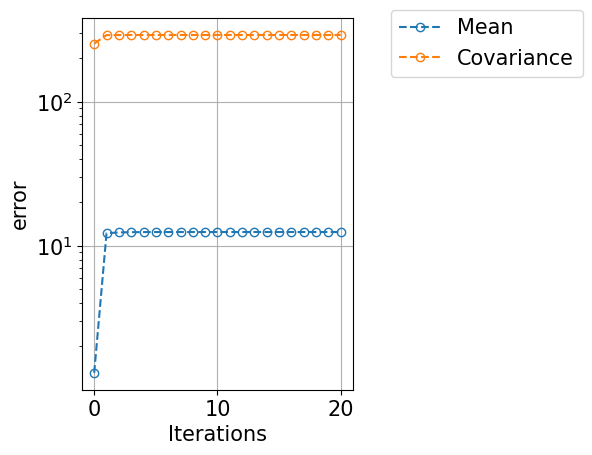

In [288]:
errors = zeros(FT, 2, N_iter+1)
for i = 1:N_iter+1
    errors[1, i] = norm(A*uki_objs.θ_mean[i] .- θ_post)
    errors[2, i] = norm(A*uki_objs.θθ_cov[i]*A' .- θθ_post)
end


ites = Array(0:N_iter)
semilogy(ites, errors[1, :], "--o", fillstyle="none", label="Mean")
semilogy(ites, errors[2, :], "--o", fillstyle="none", label="Covariance")
xlabel("Iterations")
ylabel("error")
grid("on")
legend(bbox_to_anchor=(1.1, 1.05))
tight_layout()

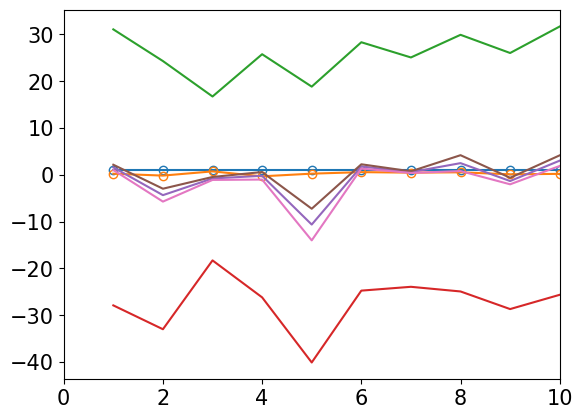

(0.0, 10.0)

In [289]:
θ_ind = Array(1:Nθ)
plot(θ_ind, θ_ref, "-o", fillstyle="none") 

std_post = sqrt.(diag(θθ_post))
plot(θ_ind, θ_post, "-o", fillstyle="none") 
plot(θ_ind, A*uki_objs.θ_mean[end] + 3std_post ) 
plot(θ_ind, A*uki_objs.θ_mean[end] - 3std_post ) 

plot(θ_ind, A*uki_objs.θ_mean[end]) 
std = sqrt.(diag(A*uki_objs.θθ_cov[end]*A'))
plot(θ_ind, A*uki_objs.θ_mean[end] + 3std  ) 
plot(θ_ind, A*uki_objs.θ_mean[end] - 3std  ) 
xlim([0,10])

In [290]:
cov = A*uki_objs.θθ_cov[end]*A'
svd(cov)


SVD{Float64, Float64, Matrix{Float64}}
U factor:
10×10 Matrix{Float64}:
 -0.134739    -0.00307939   0.979876   …  -0.0650987   0.0388026   0.00788181
  0.325508    -0.12454     -0.0260246     -0.0638703  -0.0996637  -0.00547481
  0.0748192    0.0357335   -0.0137145     -0.61804     0.479985   -0.145505
 -0.125016    -0.474029    -0.0754425     -0.272993    0.392859   -0.00107578
  0.799777    -0.296886     0.137383      -0.0355558   0.0257198   0.017004
 -0.0603987    0.30159     -0.0124108  …  -0.650339   -0.524549   -0.0875648
 -0.00954744   0.131494     0.012517       0.198378    0.162374   -0.928432
 -0.369515    -0.534509     0.0267499      0.105977   -0.122936    0.00247651
 -0.0460481   -0.523359    -0.0307668     -0.175922   -0.473901   -0.313433
 -0.269479    -0.0500742   -0.111529      -0.171597    0.248924    0.102695
singular values:
10-element Vector{Float64}:
 1.9595583268583043
 0.1824130841712978
 1.5299934114902032e-16
 3.5098034155314486e-17
 2.441805656540216e-17
 1.

# Eigenvectors from projections

Consider the projection matrix $V (V^T V)^{-1} V^T$, we have

$$ G V (V^T V)^{-1} V^T$$

# Low-rank approximation from alternating least-squares

In [301]:
Nsample = 10
K = 7
Es = []
GEs = []
for i = 1:Nsample
    Ei = rand(Normal(0.0, 1.0), Nθ, K)

    push!(Es, Ei)
    push!(GEs, G*Ei)
end

# initial guess
C = zeros(Float64, Nθ, Nθ)
for i = 1:Nsample
    P = Es[i] *((Es[i]'*Es[i])\Es[i]')
    C += (G*P)' * G*P
end
C /= Nsample*Ny
svd_C = svd(C)

Nr = 3

B0 = svd_C.U[:, 1:Nr]'

3×10 adjoint(::Matrix{Float64}) with eltype Float64:
 -0.0959727  -0.0374983  -0.699051  …  -0.369671    0.417725    0.0767582
  0.265556   -0.372075    0.327886      0.0384883   0.224513    0.210681
  0.615466    0.249984   -0.175507      0.149317   -0.0693463  -0.202393

In [302]:
# Gi Ei = Ai B Ei
# Gi is a Ny by Nθ matrix
# Ei is a Nθ by Ne matrix (Ne >= Nr)
# Ai is a Ny by Nr matrix
# B  is a Nr by Nθ matrix

function Alternating_LS(GEs, Es, Nr, B = nothing, max_iter = 100)
    K = length(GEs)
    Ny, Ne = size(GEs[1])
    Nθ, _ = size(Es[1])
    
    A = zeros(Float64, Ny*K, Nr)
    if B === nothing
        B = rand(Normal(0.0, 1.0), Nr, Nθ) 
    end
    # B .= CU'
    # debug
    # B = copy(G) 
    
    GE_b = zeros(Float64, Ny*Ne*K)
    for i = 1:K
        GE_b[1+(i-1)*Ny*Ne: i*Ny*Ne] = GEs[i][:]
    end
    
    b    = zeros(Float64, Nr*Nθ)
    AE_b = zeros(Float64, Ny*Ne*K, Nr*Nθ)
    AE = zeros(Float64, Ny, Ne, Nr, Nθ)
    losses = zeros(Float64, K)
    
    # AE_b * b = GE_b
    for iter = 1:max_iter
        @info "Alternating LS iter: ", iter
        # solve for A
        for i = 1:K
            # @info B * Es[i]
            Ai = GEs[i]/(B * Es[i])
            A[1+(i-1)Ny:i*Ny, :] .= Ai
        end
        
        # solve for B
        for i = 1:K
            Ai = A[1+(i-1)Ny:i*Ny, :]
            Ei = Es[i]
            for k1 = 1:Ny
                for k2 = 1:Ne
                    for k3 = 1:Nr
                        for k4 = 1:Nθ
                            AE[k1, k2, k3, k4] = Ai[k1,k3]*Ei[k4,k2]
                        end
                    end
                end
            end
            
            AE_b[1+(i-1)*Ny*Ne : i*Ny*Ne, :] .= reshape(AE, Ny*Ne,  Nr*Nθ)
        end
        
        @info "Size of b LS is :", size(AE_b)
        
        b .= AE_b\GE_b
        B .= reshape(b, Nr, Nθ)
        
        # compute losses
        
        
        for i = 1:K
            losses[i] = norm(GEs[i] - A[1+(i-1)Ny:i*Ny, :]*B*Es[i])
        end
        @info "loss is: ", losses
        
    end
    return B
end

B = Alternating_LS(GEs, Es, 3, B0, 100)
svd(B)

┌ Info: ("Alternating LS iter: ", 1)
└ @ Main In[302]:32
┌ Info: ("Size of b LS is :", (420, 30))
└ @ Main In[302]:57
┌ Info: ("loss is: ", [0.1411054722355773, 0.13742344675151325, 0.12137355877881296, 0.2175778993231739, 0.1086660637998625, 0.32683792942558726, 0.16324968788482933, 0.19708950488039706, 0.1265173263654769, 0.2064113488705121])
└ @ Main In[302]:68
┌ Info: ("Alternating LS iter: ", 2)
└ @ Main In[302]:32
┌ Info: ("Size of b LS is :", (420, 30))
└ @ Main In[302]:57
┌ Info: ("loss is: ", [0.05752893206040921, 0.06978766571219314, 0.0687439492407436, 0.07178281493287234, 0.048320211664915555, 0.10115780815406297, 0.0852659538114226, 0.06829327645795384, 0.08129637834404446, 0.06647820223094585])
└ @ Main In[302]:68
┌ Info: ("Alternating LS iter: ", 3)
└ @ Main In[302]:32
┌ Info: ("Size of b LS is :", (420, 30))
└ @ Main In[302]:57
┌ Info: ("loss is: ", [0.027174143452850293, 0.03948379782507976, 0.048609670502825955, 0.03255283606955772, 0.025992606633640586, 0.05569024095

┌ Info: ("loss is: ", [1.0325111713277225e-5, 8.163236398221625e-6, 7.56979153593259e-6, 5.774452197333169e-6, 3.30835091886076e-6, 1.1538312958023708e-5, 1.5125949845864248e-7, 5.063283265604457e-6, 5.6576349544416474e-6, 4.9720436864213365e-6])
└ @ Main In[302]:68
┌ Info: ("Alternating LS iter: ", 30)
└ @ Main In[302]:32
┌ Info: ("Size of b LS is :", (420, 30))
└ @ Main In[302]:57
┌ Info: ("loss is: ", [7.489058653478801e-6, 5.891961671852985e-6, 5.58406289543111e-6, 4.2348465444706004e-6, 2.4125866505601654e-6, 8.54771624426324e-6, 8.686014071948881e-8, 3.7563929314269504e-6, 4.127816862847401e-6, 3.692691274825188e-6])
└ @ Main In[302]:68
┌ Info: ("Alternating LS iter: ", 31)
└ @ Main In[302]:32
┌ Info: ("Size of b LS is :", (420, 30))
└ @ Main In[302]:57
┌ Info: ("loss is: ", [5.449509703943945e-6, 4.2681633650300104e-6, 4.119941545663758e-6, 3.11102137619196e-6, 1.7637377716108497e-6, 6.331050704485313e-6, 5.014225008262764e-8, 2.786078383752072e-6, 3.0187538526440636e-6, 2.74465

┌ Info: ("loss is: ", [1.8788801623911946e-9, 1.426610772172963e-9, 1.5210035534907412e-9, 1.130925093755342e-9, 6.278912971943425e-10, 2.3982911334397866e-9, 5.603053214481858e-14, 1.0700974298116898e-9, 1.0727703075108824e-9, 1.0767766981309493e-9])
└ @ Main In[302]:68
┌ Info: ("Alternating LS iter: ", 58)
└ @ Main In[302]:32
┌ Info: ("Size of b LS is :", (420, 30))
└ @ Main In[302]:57
┌ Info: ("loss is: ", [1.3861660045035517e-9, 1.0523934467768707e-9, 1.1223114498683293e-9, 8.344709882651749e-10, 4.6328244843054156e-10, 1.769773852471228e-9, 3.4076788163719324e-14, 7.8972615122117e-10, 7.91525144691868e-10, 7.946817982454358e-10])
└ @ Main In[302]:68
┌ Info: ("Alternating LS iter: ", 59)
└ @ Main In[302]:32
┌ Info: ("Size of b LS is :", (420, 30))
└ @ Main In[302]:57
┌ Info: ("loss is: ", [1.0226851841382086e-9, 7.763674803763878e-10, 8.281277025202376e-10, 6.157313167278835e-10, 3.418303645938318e-10, 1.3059593388777838e-9, 1.977070040073582e-14, 5.828026964496235e-10, 5.840195438

┌ Info: ("loss is: ", [2.0554245971651238e-13, 1.5585463171446937e-13, 1.6615243142513946e-13, 1.2388367544062228e-13, 6.902684275389584e-14, 2.6271424632067794e-13, 1.937212005269879e-15, 1.173348536673636e-13, 1.1748058047291256e-13, 1.180581876372151e-13])
└ @ Main In[302]:68
┌ Info: ("Alternating LS iter: ", 88)
└ @ Main In[302]:32
┌ Info: ("Size of b LS is :", (420, 30))
└ @ Main In[302]:57
┌ Info: ("loss is: ", [1.5117422362273433e-13, 1.1515685709029356e-13, 1.2276371272605191e-13, 9.13740458293931e-14, 5.102457696721721e-14, 1.937428128678669e-13, 1.936070939475553e-15, 8.594132162462468e-14, 8.664018693970339e-14, 8.637839322976947e-14])
└ @ Main In[302]:68
┌ Info: ("Alternating LS iter: ", 89)
└ @ Main In[302]:32
┌ Info: ("Size of b LS is :", (420, 30))
└ @ Main In[302]:57
┌ Info: ("loss is: ", [1.1164122772488722e-13, 8.503313068346704e-14, 9.110577799515231e-14, 6.734158487689941e-14, 3.722635969708145e-14, 1.4363979744180978e-13, 1.4409487236056747e-15, 6.30297024064279e-1

SVD{Float64, Float64, Adjoint{Float64, Matrix{Float64}}}
U factor:
3×3 adjoint(::Matrix{Float64}) with eltype Float64:
  0.954392   -0.280775  -0.101495
 -0.289048   -0.954078  -0.0786592
  0.0747481  -0.104408   0.991722
singular values:
3-element Vector{Float64}:
 1.0293744728997574
 0.9891806656790295
 0.00012986487802116642
Vt factor:
3×10 adjoint(::Matrix{Float64}) with eltype Float64:
 -0.0994095  0.102964  -0.761116   …  -0.439677    0.328923  -0.0107622
 -0.23981    0.365335  -0.115552       0.0191403  -0.304596  -0.209577
  0.219939   0.274936  -0.0145506      0.355037    0.463093  -0.194583

In [303]:
svd(G)

SVD{Float64, Float64, Matrix{Float64}}
U factor:
6×6 Matrix{Float64}:
 -0.354728   1.2297e-16   0.435505    0.222728   0.41951    0.677427
 -0.638698  -0.369802    -0.268536    0.514704  -0.316226  -0.135209
  0.183444  -0.204917     0.787806    0.138775  -0.515505  -0.136798
  0.228355  -0.894447    -0.110374   -0.278843   0.141418   0.194637
  0.387176  -0.10742      0.0463407   0.653362   0.524485  -0.366664
 -0.480136  -0.0983906    0.321333   -0.401968   0.40396   -0.575996
singular values:
6-element Vector{Float64}:
 1.0
 0.9999999999999992
 1.4104301742996381e-16
 5.654136093213245e-17
 3.317102047484654e-17
 9.573723179254646e-18
Vt factor:
6×10 Matrix{Float64}:
 -0.135624    0.235108   0.353742  …   0.27385    -0.439737    -0.163255
  0.221355   -0.297984   0.683751      0.344519   -0.0871557    0.131856
 -0.927413   -0.0773643  0.205832      0.0569542   0.199472     0.118866
 -0.0913022   0.521691   0.109252     -0.461187    0.00240201   0.0242699
  0.0887321   0.406396   0.1

In [304]:
@info svd(B)
(Vt_ref/svd(B).Vt[1:2, :])*svd(B).Vt[1:2, :] 
# @info Vt_ref


┌ Info: SVD{Float64, Float64, Adjoint{Float64, Matrix{Float64}}}([0.9543920620219664 -0.2807750897620582 -0.10149453639761666; -0.28904758908183914 -0.9540776821266559 -0.07865918709091879; 0.07474813171869438 -0.10440845481538363 0.9917215291439574], [1.0293744728997574, 0.9891806656790295, 0.00012986487802116642], [-0.09940951264330802 0.10296359375810968 -0.7611159414872037 0.05131264637769024 -0.08811372842198067 -0.16062274572622903 0.24980029661542674 -0.43967679773488616 0.32892307272731147 -0.010762206242657456; -0.23981024158858205 0.3653347424734637 -0.11555247369461326 0.5526748002657748 -0.19172297926334897 -0.24079021852167967 -0.5083449997719589 0.019140250428811567 -0.3045961354354657 -0.20957657581450123; 0.2199393797178918 0.27493624633519936 -0.01455061210139922 0.49938333646595834 0.2580474396051479 0.3884740084339956 0.1748476194858305 0.3550370386315177 0.46309295555369856 -0.1945833549122679])
└ @ Main In[304]:1


6×10 Matrix{Float64}:
 -0.217086     0.290634    -0.694283    …   0.100612    -0.126787
  0.142354    -0.244137    -0.332597        0.43686      0.167222
  1.8136e-7   -1.81835e-7   1.47696e-6     -6.56497e-7   1.02002e-8
  7.69623e-7  -7.71639e-7   6.26766e-6     -2.78592e-6   4.32857e-8
  4.24073e-7  -4.25184e-7   3.45357e-6     -1.53508e-6   2.3851e-8
  9.616e-7    -9.64119e-7   7.83108e-6  …  -3.48085e-6   5.4083e-8

In [305]:
Vt_ref

6×10 Matrix{Float64}:
 -0.217089   0.29063   -0.694283  …  -0.352759    0.100607  -0.126785
  0.142352  -0.24414   -0.332597     -0.263151    0.436856   0.167224
 -0.042953   0.563266  -0.108486      0.25271    -0.410811  -0.239353
 -0.493812  -0.150938  -0.270429     -0.0941161  -0.327595   0.310642
  0.474961  -0.120046  -0.27785       0.265471   -0.197671   0.548539
 -0.246922  -0.511317   0.206827  …  -0.328265   -0.375342  -0.149281